# ABOVE AC9 Data Processing  

## Averaging replicates

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson

**Last Updated:** September 19th, 2018

### Import libraries

In [1]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec
import inspect

### Functions

Built-in tools for this package (so far!)

In [2]:
from fopt_toolkit import fopt_toolkit as fp
for i in inspect.getmembers(fp, inspect.isfunction):
    print i[0]

get_id
make_dir
plotting_multiple_files


## Inputs

In [6]:
fp.make_dir('Data/3_1_averaged_summary_stats')
fp.make_dir('Figures/Averaged_reps')

### Upload metadata file with filepaths

In [5]:
metadata_updated = pd.read_csv('../Metadata/project_metadata_updated.csv', dtype={'Date': object, 'Rep':object}, skiprows=0, delimiter= '\t')



## Average replicates - FOR NOW taking them from 'passed manual removal' folder rather than the to-be-made 'passed second removal' folder. FIX LATER

** Makeing filepath_dict to store files for averaging. filepath_dict keys are combinations of site, analysis type (a or c), and sample_type (fil or raw, skipping cal); entries are dictionaries containing the replicate dataframes for those variables, separated into different dataframes for means and stds **

Initializing dictionary

In [59]:
### Subset the metadata to only use data that has passed both removal steps
### AND does not include calibration data
temp = metadata_updated[metadata_updated['Pass_Manual_Removal'] == 'pass'][metadata_updated['Pass_Second_Removal'] == 'pass'][metadata_updated['Sample_Type'] != 'cal']

##Empty dictionary to store dataframes for averaging
filepath_dict = {}
## Iterate through all possible unique combinations of site, analysis type, and sample type
for i in set(temp['Site']+'_'+temp['Analysis_Type']+'_'+temp['Sample_Type']):
    ## Entries of dictionary are a dictionary with entries 'mean' and 'std
    filepath_dict[i] = {'mean':[], 'std':[]}


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Filling dictionary

In [60]:
### iterate through the rows of the subsetted metadata
for index, row in temp.iterrows():
    ## Get information for each row to match the key value of filepath_dict
    site = row['Site']
    analysis_type = row['Analysis_Type']
    sample_type = row['Sample_Type']
    key_value = site+'_'+analysis_type+'_'+sample_type
    ## Read in the csv based on the filepath
    df = pd.read_csv(row['Summary_file_path_cleaned_MANUAL'], skiprows = 0, delimiter= '\t')         
    df.reset_index(inplace=True, drop=False)
    ## Rename columns so we don't have to write multiple lines of code
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    ## store means and stds separately for each set of reps to be averaged
    ## Becaue they require different operations
    ## (index values are wavelengths)
    filepath_dict[key_value]['mean'].append(df[['wl','mean']].set_index('wl'))
    filepath_dict[key_value]['std'].append(df[['wl','std']].set_index('wl'))

** Custom aggregation function for combining standard deviations: for standard deviations x and y, combined std = sqrt(x^2 + y^2) **

In [89]:
def combine_std(series):
    from math import sqrt
    return sqrt(sum([i**2 for i in series]))

In [143]:
averaged_files = {i.split('_')[0]:{'a':{'fil':None,'raw':None},'c':{'fil':None,'raw':None}} for i in filepath_dict}
for i in filepath_dict:
    site = i.split('_')[0]
    a_type = i.split('_')[1]
    s_type = i.split('_')[2]
    means = pd.concat(filepath_dict[i]['mean']).groupby(level=0).mean()
    stds = pd.concat(filepath_dict[i]['std']).groupby(level=0).agg(combine_std)
    #temp_series = temp_series.to_frame(name=i)
    means['std'] = stds['std']
    averaged_files[site][a_type][s_type] = means

In [ ]:
plt.savefig('../Figures/Check_compared_reps/'+i+'.png', bbox_inches='tight')

In [164]:
def plotting_multiple_files(dict_of_files, title='Title'):
    linestyles = {'fil':'--','raw':'-'}
    for reps in sorted(list(dict_of_files)):
        Sample_Type = reps.split(' ')[0]
        if not isinstance(dict_of_files[reps], pd.DataFrame):
            df = pd.read_csv(dict_of_files[reps], skiprows = 0, delimiter= '\t')
        else:
            df = dict_of_files[reps]
        df.reset_index(inplace=True, drop=False)
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        plt.plot('wl','mean',data=df,label=reps,linestyle=linestyles[Sample_Type])
        plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
    plt.ylabel('[1/m]')
    plt.xlabel('Wavelength (nm)')
    plt.title(title)
    plt.legend(sorted(list(dict_of_files)))
    return plt

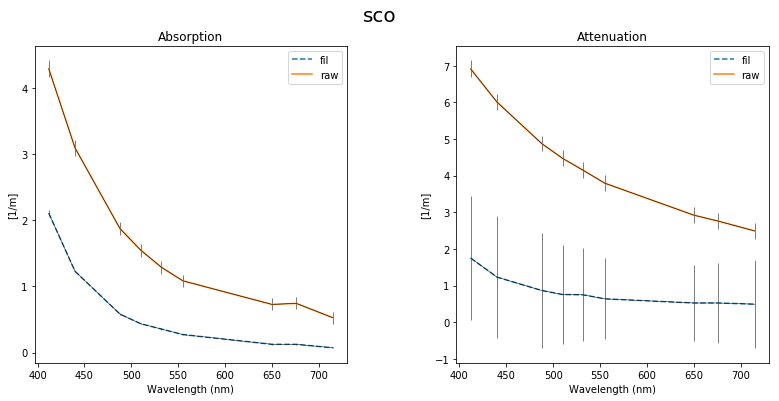

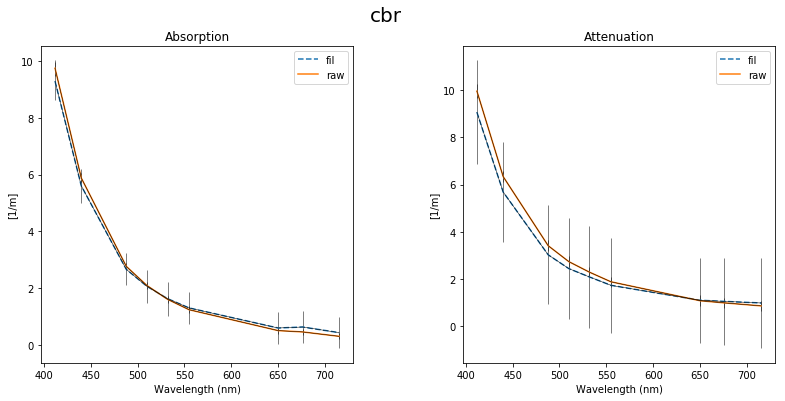

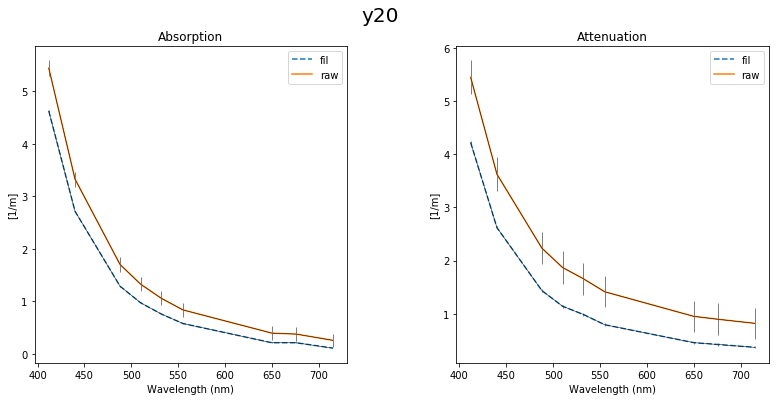

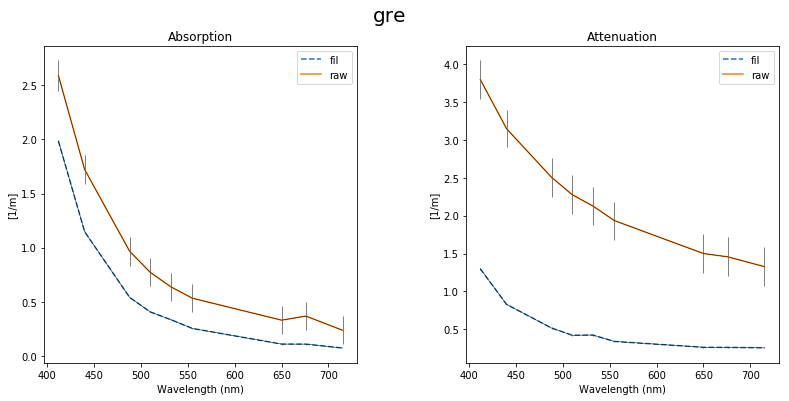

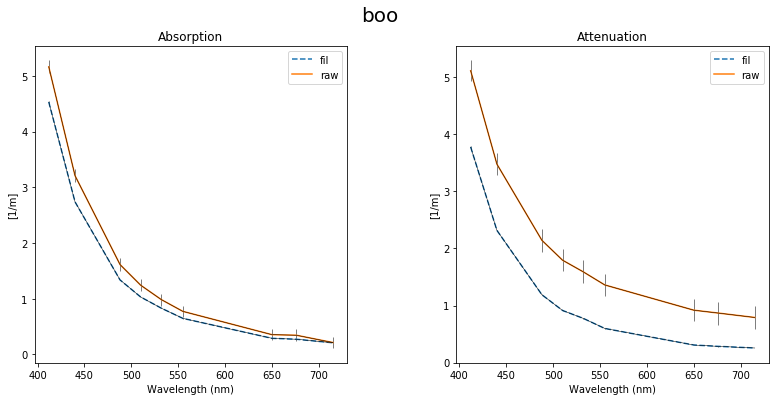

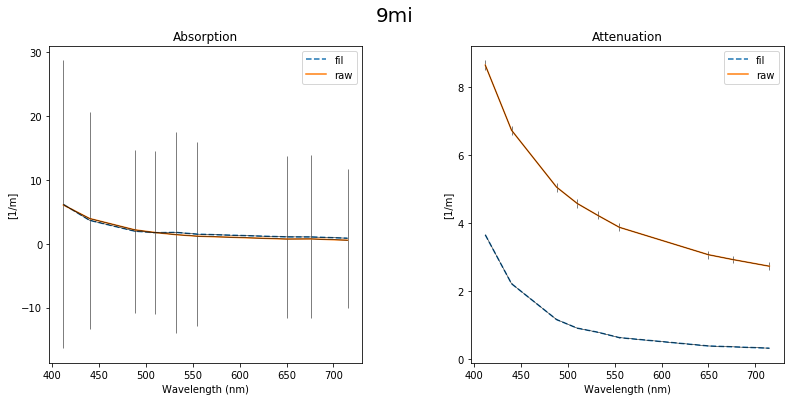

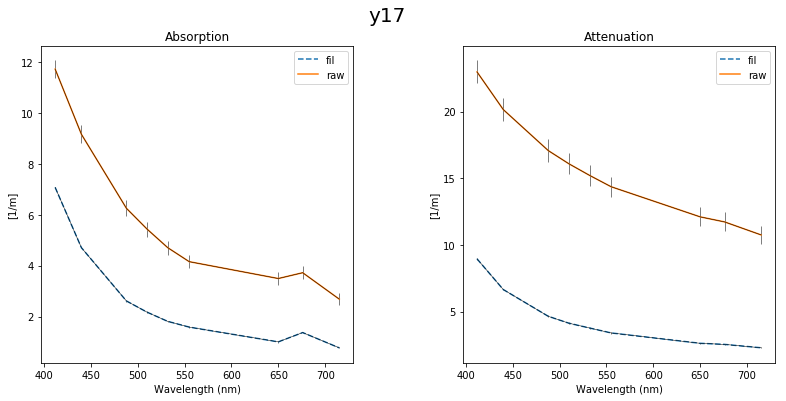

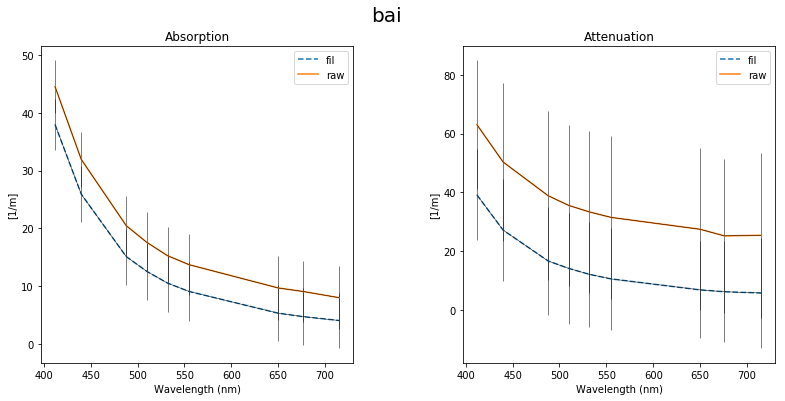

In [163]:
for i in averaged_files:
    absorption = averaged_files[i]['a']
    attenuation = averaged_files[i]['c']
    plt.subplots(1, 2, figsize=(12, 5.5))
    plt.subplot(1, 2, 1)
    plotting_multiple_files(absorption, title='Absorption')
    plt.subplot(1, 2, 2)
    attenuation_graph = plotting_multiple_files(attenuation, title='Attenuation')
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle(i, fontsize=20)
    #plt.savefig('../Figures/Check_compared_reps/'+i+'.png', bbox_inches='tight')
    plt.show()

## Finding a statistic to check for significant differences between reps....hmm

In [46]:
mydf.to_csv('/Users/Petrichor/Desktop/stat_check.csv')

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



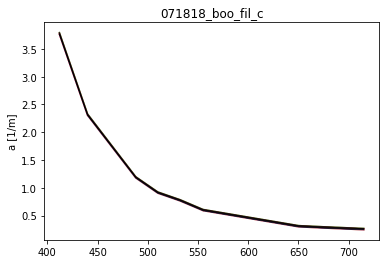

In [42]:
### Generate a dataframe including all reps, with a column denoting the reps
replicates = []
for filename in dict_of_files['071818_boo_fil_c']:
    Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
    df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    df['Rep'] = str(Rep)
    #print df
    replicates.append(df)
mydf = pd.concat(replicates)
mydf['wl'].apply(str)
mydf

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())
plotting_absorption(dict_of_files['071818_boo_fil_c'], title='071818_boo_fil_c').show()

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



In [31]:
for sampleid in dict_of_files:
    replicates = []
    for filename in dict_of_files[sampleid]:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
        df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        df['Rep'] = str(Rep)
        replicates.append(df)
    pd.concat(replicates)
    print replicates

[   Unnamed: 0     wl      mean       std  a_median     a_IQR Rep
0           0  412.0  0.591976  0.192675  0.617685  0.008013   1
1           1  440.0  0.346809  0.071495  0.356950  0.004217   1
2           2  488.0  0.188092  0.049426  0.194855  0.003827   1
3           3  510.0  0.143578  0.048618  0.150565  0.002998   1
4           4  532.0  0.137895  0.058832  0.146140  0.003405   1
5           5  555.0  0.103731  0.053839  0.111425  0.003502   1
6           6  650.0  0.053382  0.049377  0.061460  0.002745   1
7           7  676.0  0.065272  0.048239  0.073180  0.002865   1
8           8  715.0  0.036092  0.039795  0.041720  0.002842   1,    Unnamed: 0     wl      mean       std  a_median    a_IQR Rep
0           0  412.0  0.617012  0.004101   0.61732  0.00548   2
1           1  440.0  0.354836  0.002537   0.35480  0.00348   2
2           2  488.0  0.194446  0.002171   0.19426  0.00292   2
3           3  510.0  0.150545  0.001838   0.15040  0.00236   2
4           4  532.0  0.1459